Estimation error
[-0.37304737  0.71365846 -0.26604634]
Estimation precision
[0.53554157 0.34698788 0.73646111]
Estimation error
[-0.32379018 -0.09668446 -0.46237827]
Estimation precision
[6.25666514 2.0959485  8.08593075]
Estimation error
[ 0.17213319 -0.12769893  0.19784196]
Estimation precision
[16.56381761 15.37641505 11.67419999]
Estimation error
[0.20276901 0.25891798 0.24637927]
Estimation precision
[44.23851311 17.65554795 16.03789658]
Estimation error
[-0.12710833  0.23204116 -0.06745794]
Estimation precision
[66.3791926  26.3616375  19.70287587]
Estimation error
[-0.08838173  0.03672115  0.24954947]
Estimation precision
[84.74932039 39.64091536 21.98352107]
Estimation error
[ 0.10650104 -0.33769703 -0.0252909 ]
Estimation precision
[86.02789837 42.59155175 24.54620633]
Estimation error
[-0.12202128 -0.26901665 -0.43054382]
Estimation precision
[87.28829779 44.87529263 26.35701581]
Estimation error
[ 0.1325186  -0.09487415  0.1940061 ]
Estimation precision
[92.63604961 64.75829

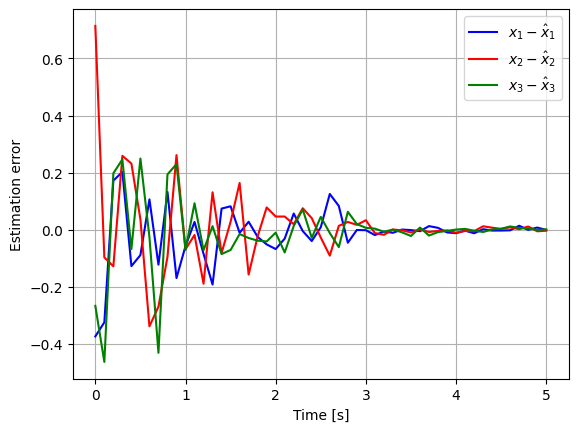

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Measurand
x = np.array([10, 5, -5]).reshape(-1, 1)
n = len(x)

# Time steps
Dt = 0.1  # Sampling time [s]
t = np.arange(0, 5 + Dt, Dt)

# Time evolution of the estimates
x_err = np.zeros((n, len(t)))

H = np.empty((0, n))
MU = np.empty((0, 1))
R = np.empty((0, 0))

for i in range(len(t)):
    
    # Sensor
    delta_n_sensor = 5  # Arbitrary number of sensors, > 0
    n_sensor = int(np.round(np.random.rand() * (delta_n_sensor + n)))
    H_step = np.random.rand(n_sensor, n)
    
    if i == 0:
        while n_sensor < n and np.linalg.matrix_rank(H_step) < n:
            n_sensor = int(np.round(np.random.rand() * (delta_n_sensor + n)))
            H_step = np.random.rand(n_sensor, n)
    
    # Sensors uncertainties
    mu_eps = np.zeros((n_sensor, 1))
    R_eps = np.random.rand(n_sensor, n_sensor)
    R_eps = R_eps @ R_eps.T

    # Measurements
    R = np.block([[R, np.zeros((R.shape[0], R_eps.shape[1]))], 
                  [np.zeros((R_eps.shape[0], R.shape[1])), R_eps]])
    H = np.vstack((H, H_step))
    MU = np.vstack((MU, mu_eps))
    
    z = H @ x + np.random.multivariate_normal(MU.flatten(), R).reshape(-1, 1)

    # Estimator
    P = np.linalg.inv(H.T @ np.linalg.inv(R) @ H)
    x_est = P @ H.T @ np.linalg.inv(R) @ z

    # Estimation error
    x_err[:, i] = (x - x_est).flatten()
    print("Estimation error")
    print(x_err[:, i])
    print("Estimation precision")
    print(1.0 / np.diag(P))

# Plotting
LType = ['b-', 'r-', 'g-', 'k-', 'b-.', 'r-.', 'g-.', 'k-.', 'b--', 'r--', 'g--', 'k--']

plt.figure()
for i in range(n):
    plt.plot(t, x_err[i, :], LType[i])
    plt.legend([f'$x_{i+1} - \\hat{{x}}_{i+1}$' for i in range(n)], loc='best')

plt.xlabel('Time [s]')
plt.ylabel('Estimation error')
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation setup
SetUp = {
    "Dt": 0.1,  # [s]
    "Time": np.arange(0, 100 + 0.1, 0.1),  # [s]
}

# Environment
Env = {
    "MaxX": 30,
    "MaxY": 30,
    "GasLeakPos": np.random.rand(2) * np.array([30, 30])
}

# Robots
Rob = {
    "n": 5,
    "A": np.eye(2),
    "B": np.eye(2),
    "InitState": [np.random.rand(2) * np.array([30, 30]) for _ in range(5)],
    "State": [np.zeros((2, len(SetUp["Time"]))) for _ in range(5)],
    "GLDetected": np.zeros(5),
    "MaxVel": 2,  # [m/s]
    "Inputs": [(np.random.rand(2, 1) - 0.5) * 2 * 2 * np.ones((2, len(SetUp["Time"]))) for _ in range(5)],
    "GLN": {
        "MaxDist": 5,  # [m]
        "mu": 0,  # [m]
        "sigma": 0.1,  # [m]
        "PosMu": np.zeros(2),
        "PosCov": np.random.rand(2, 2) * 0.5,
        "PosMeas": np.zeros((2, 5)),
        "H": np.eye(2),
    },
    "Cons": {
        "Adj": np.zeros((5, 5)),
        "nMsg": 10,
        "Degree": np.zeros(5),
        "F": [None] * 5,
        "a": [None] * 5,
        "FlagUsePrevEst": 0,
    }
}

# Initialize robot states
for i in range(Rob["n"]):
    Rob["State"][i][:, 0] = Rob["InitState"][i]

# Symmetric positive definite covariance matrix for gas leak position
Rob["GLN"]["PosCov"] = np.dot(Rob["GLN"]["PosCov"].T, Rob["GLN"]["PosCov"])

# Simulation
for k in range(len(SetUp["Time"]) - 1):
    # Detection
    for i in range(Rob["n"]):
        distance = np.linalg.norm(Rob["State"][i][:, k] - Env["GasLeakPos"])
        detection_noise = np.abs(np.random.randn() * Rob["GLN"]["sigma"])
        if distance <= Rob["GLN"]["MaxDist"] - detection_noise and Rob["GLDetected"][i] == 0:
            # Stop the robot
            Rob["Inputs"][i][:, k:] = np.zeros((2, len(SetUp["Time"]) - k))
            Rob["GLDetected"][i] = 1
        
        if Rob["GLDetected"][i]:
            Rob["GLN"]["PosMeas"][:, i] = Env["GasLeakPos"] + np.random.multivariate_normal(Rob["GLN"]["PosMu"], Rob["GLN"]["PosCov"])

    # Consensus
    for i in range(Rob["n"]):
        if Rob["GLDetected"][i]:
            for j in range(Rob["n"]):
                if j != i:
                    Rob["Cons"]["Adj"][j, i] = 1

    for i in range(Rob["n"]):
        Rob["Cons"]["Degree"][i] = np.sum(Rob["Cons"]["Adj"][i, :])

    for i in range(Rob["n"]):
        if Rob["GLDetected"][i]:
            if Rob["Cons"]["FlagUsePrevEst"] == i:
                S = np.dot(Rob["GLN"]["H"], np.linalg.inv(Rob["Cons"]["F"][i])).dot(Rob["GLN"]["H"].T) + Rob["GLN"]["PosCov"]
                W = np.linalg.inv(Rob["Cons"]["F"][i]).dot(Rob["GLN"]["H"].T).dot(np.linalg.inv(S))
                z = np.linalg.inv(Rob["Cons"]["F"][i]).dot(Rob["Cons"]["a"][i]) + W.dot(Rob["GLN"]["PosMeas"][:, i] - Rob["GLN"]["H"].dot(np.linalg.inv(Rob["Cons"]["F"][i])).dot(Rob["Cons"]["a"][i]))
                P = np.eye(2) - W.dot(Rob["GLN"]["H"]).dot(np.linalg.inv(Rob["Cons"]["F"][i]))
                Rob["Cons"]["F"][i] = np.dot(Rob["GLN"]["H"].T, np.linalg.inv(P)).dot(Rob["GLN"]["H"])
                Rob["Cons"]["a"][i] = np.dot(Rob["GLN"]["H"].T, np.linalg.inv(P)).dot(z)
            else:
                Rob["Cons"]["F"][i] = np.dot(Rob["GLN"]["H"].T, np.linalg.inv(Rob["GLN"]["PosCov"])).dot(Rob["GLN"]["H"])
                Rob["Cons"]["a"][i] = np.dot(Rob["GLN"]["H"].T, np.linalg.inv(Rob["GLN"]["PosCov"])).dot(Rob["GLN"]["PosMeas"][:, i])

    # Consensus rounds
    StoreEst = np.zeros((Rob["n"], Rob["Cons"]["nMsg"] + 1, 2))
    for i in range(Rob["n"]):
        StoreEst[i, 0, :] = np.linalg.inv(Rob["Cons"]["F"][i]).dot(Rob["Cons"]["a"][i])

    for nMsg in range(1, Rob["Cons"]["nMsg"] + 1):
        F = Rob["Cons"]["F"].copy()
        a = Rob["Cons"]["a"].copy()

        for i in range(Rob["n"]):
            for j in range(Rob["n"]):
                if Rob["Cons"]["Adj"][i, j]:
                    q_ij = 1 / (max(Rob["Cons"]["Degree"][i], Rob["Cons"]["Degree"][j]) + 1)
                    Rob["Cons"]["F"][i] += q_ij * (F[j] - F[i])
                    Rob["Cons"]["a"][i] += q_ij * (a[j] - a[i])

        for i in range(Rob["n"]):
            StoreEst[i, nMsg, :] = np.linalg.inv(Rob["Cons"]["F"][i]).dot(Rob["Cons"]["a"][i])

    for i in range(Rob["n"]):
        if Rob["GLDetected"][i]:
            Rob["Cons"]["FlagUsePrevEst"] = i

    if np.sum(Rob["GLDetected"]) >= 2:
        plt.figure(2)
        plt.clf()
        plt.hold(True)
        LegS = []
        for i in range(Rob["n"]):
            plt.plot(range(Rob["Cons"]["nMsg"] + 1), StoreEst[i, :, 0])
            LegS.append(f'r_{i + 1}')
        plt.plot(range(Rob["Cons"]["nMsg"] + 1), Env["GasLeakPos"][0] * np.ones(Rob["Cons"]["nMsg"] + 1), 'r--')
        LegS.append('Actual pos')
        plt.xlabel('Number of messages')
        plt.ylabel('x [m]')
        plt.legend(LegS, loc='best')
        plt.show()

        plt.figure(3)
        plt.clf()
        plt.hold(True)
        LegS = []
        for i in range(Rob["n"]):
            plt.plot(range(Rob["Cons"]["nMsg"] + 1), StoreEst[i, :, 1])
            LegS.append(f'r_{i + 1}')
        plt.plot(range(Rob["Cons"]["nMsg"] + 1), Env["GasLeakPos"][1] * np.ones(Rob["Cons"]["nMsg"] + 1), 'r--')
        LegS.append('Actual pos')
        plt.xlabel('Number of messages')
        plt.ylabel('y [m]')
        plt.legend(LegS, loc='best')
        plt.show()

    # Motion
    for i in range(Rob["n"]):
        Rob["State"][i][:, k + 1] = Rob["A"].dot(Rob["State"][i][:, k]) + SetUp["Dt"] * Rob["B"].dot(Rob["Inputs"][i][:, k])
        while (Rob["State"][i][0, k + 1] >= Env["MaxX"] or Rob["State"][i][0, k + 1] <= 0 or
               Rob["State"][i][1, k + 1] >= Env["MaxY"] or Rob["State"][i][1, k + 1] <= 0):
            Rob["Inputs"][i][:, k:] = (np.random.rand(2, 1) - 0.5) * 2 * Rob["MaxVel"] * np.ones((2, len(SetUp["Time"]) - k))
            Rob["State"][i][:, k + 1] = Rob["A"].dot(Rob["State"][i][:, k]) + SetUp["Dt"] * Rob


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional